#**Imports**#

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/'ImageProcessing_Assignment.zip (Unzipped Files)'/assignment/

/content/drive/MyDrive/ImageProcessing_Assignment.zip (Unzipped Files)/assignment


In [5]:
from exGenerator import *

#**Show images**#

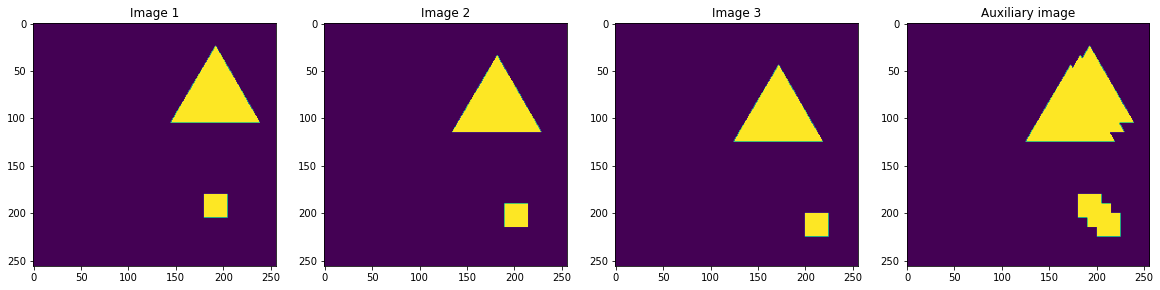

In [9]:
matricola = '1937430'
im1, im2, im3, im4 = ex11(matricola)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
ax1.imshow(im1)
ax1.set_title("Image 1")
ax2.imshow(im2)
ax2.set_title("Image 2")
ax3.imshow(im3)
ax3.set_title("Image 3")
ax4.imshow(im4)
ax4.set_title("Auxiliary image")
print("")

In [12]:
path1 = 'im1_11.jpg'
path2 = 'im2_11.jpg'
path3 = 'im3_11.jpg'

im1.save(path1)
im2.save(path2)
im3.save(path3)

#**Image Segmentation with Watershed Algorithm**#

https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

In [11]:
def watershed(img_path):
  img = cv2.imread(img_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  #noise removal
  kernel = np.ones((3,3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  #sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations=3)

  #finding sure foreground area
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

  #finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg, sure_fg)

  #marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)

  #add one to all labels so that sure background is not 0, but 1
  markers = markers + 1
  #now, mark the region of unknown with zero
  markers[unknown==255] = 0

  markers = cv2.watershed(img, markers)

  img[markers == -1] = [255, 0, 0]

  return img

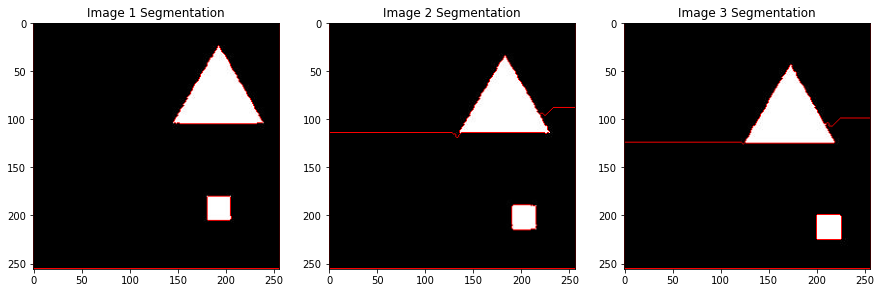

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))
ax1.imshow(watershed(path1))
ax1.set_title("Image 1 Segmentation")
ax2.imshow(watershed(path2))
ax2.set_title("Image 2 Segmentation")
ax3.imshow(watershed(path3))
ax3.set_title("Image 3 Segmentation")
print("")

#**Dense Optical Flow**#

In [20]:
#list of frames - segmented images
frames = [watershed(path1), watershed(path2), watershed(path3)]
#pick the first frame
first_frame = frames[0]
#convert to gray-scale
prev_gray = cv2.cvtColor(first_frame,cv2.COLOR_BGR2GRAY)

#create mask
mask = np.zeros_like(first_frame)
#set image saturation to maximum value as we do not need it
mask[...,1] = 255

#store results to show later
flows = []
i = 1
while(i < 3):
    #get new frame
    next_frame = frames[i]
    gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    #calculate dense optical flow by Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 5,
                                        winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
    #compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[...,0], flow[...,1])
    #set image hue according to the optical flow direction
    mask[...,0] = angle * 180 / np.pi / 2
    #set image value according to the optical flow magnitude (normalized)
    mask[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    #convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

    #open a new window and displays the output frame
    dense_flow = cv2.addWeighted(next_frame, 1, rgb, 2, 0)
    flows.append(dense_flow)
    #update previous frame
    prev_gray = gray
    i += 1

cv2.destroyAllWindows()

##**Frame 1 -> Frame 2**   and   **Frame 2 -> Frame 3**##

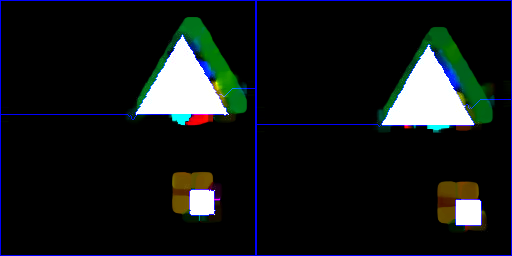

In [35]:
final_img = cv2.hconcat((flows[0], flows[1]))
cv2_imshow(final_img)

Triangle is moving to the center, square is diverging to the borders.
